### Analysis sales performance using data from AdventureWorks2008R2 database

In [61]:
# Importing necessary Python libraries

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
# Setting up connection to the database

conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-M71B6JJ;'
                      'Database=AdventureWorks2008R2;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
cursor.execute('SELECT TOP 1 * FROM DatabaseLog')

for row in cursor:
    print(row[0:5]) # check to make sure the connection is established.

(1, datetime.datetime(2012, 3, 29, 13, 52, 1, 163000), 'dbo', 'CREATE_TABLE', 'dbo')


#### 1)  Summarize internet (online) sales and reseller sales by territory

In [63]:
# Retrieving sales inforamtion from Sales.SalesOrderHeader table

df_SalesOrderHeader = pd.read_sql("""SELECT SalesOrderID,
                                            OnlineOrderFlag,
                                            SalesOrderNumber,
                                            SalesPersonID,
                                            TerritoryID,
                                            TotalDue
                                    FROM sales.SalesOrderHeader; """, conn)
df_SalesOrderHeader.head(2)

,SalesOrderID,OnlineOrderFlag,SalesOrderNumber,SalesPersonID,TerritoryID,TotalDue
0,43659,False,SO43659,279.0,5,23153.2339
1,43660,False,SO43660,279.0,5,1457.3288


In [64]:
# Checking for the size and missing values in df_SalesOrderHeader

print('(row, columns) =', df_SalesOrderHeader.shape, '\n')
print(df_SalesOrderHeader.isnull().sum())

(row, columns) = (31465, 6) 

SalesOrderID            0
OnlineOrderFlag         0
SalesOrderNumber        0
SalesPersonID       27659
TerritoryID             0
TotalDue                0
dtype: int64


In [65]:
# Counting number of online sales.

df_SalesOrderHeader[df_SalesOrderHeader.OnlineOrderFlag==True].notnull().sum()

SalesOrderID        27659
OnlineOrderFlag     27659
SalesOrderNumber    27659
SalesPersonID           0
TerritoryID         27659
TotalDue            27659
dtype: int64

Based on the above analysis, there were 27659 online transections and they didn't involve a sales representative.    

In [66]:
""" Retriving sales data by territory and by online and reseller sales by joining sales.SalesOrderHeader 
    and Sales.SalesTerritory tables.""" 

df_terri = pd.read_sql("""SELECT  st.TerritoryID, 
                                  st.Name AS TerriName,
                                  sh.OnlineOrderFlag,
                                  SUM(sh.TotalDue) as Total
                                FROM sales.SalesOrderHeader sh
                                INNER JOIN Sales.SalesTerritory st ON st.TerritoryID = sh.TerritoryID
                                GROUP BY  st.TerritoryID, st.Name, sh.OnlineOrderFlag
                                ORDER BY st.TerritoryID, st.Name, sh.OnlineOrderFlag; """, conn)
df_terri.head(2)

,TerritoryID,TerriName,OnlineOrderFlag,Total
0,1,Northwest,False,1.402856e+07
1,1,Northwest,True,4.033103e+06


In [67]:
# Checking for the size and missing values in df_terri

print('(row, columns) =', df_terri.shape, '\n')
print(df_terri.isnull().sum())

(row, columns) = (20, 4) 

TerritoryID        0
TerriName          0
OnlineOrderFlag    0
Total              0
dtype: int64


In [70]:
""" Transforming the dataframe so that OnlineOrderFlag's True and False values are in different columns 
    so the ratio of online sales and reseller sales can be calculated. """

# Getting a new dataframe that only contains online sales data
df_terri1 = df_terri[df_terri.OnlineOrderFlag == True]

# Getting a new dataframe that only contains reseller sales data
df_terri2 = df_terri[df_terri.OnlineOrderFlag == False]

# Merging the two new dataframes
df_terri1 = df_terri1.merge(df_terri2, how='inner', on='TerritoryID')
df_terri1

,TerritoryID,TerriName_x,OnlineOrderFlag_x,Total_x,TerriName_y,OnlineOrderFlag_y,Total_y
0,1,Northwest,True,4.033103e+06,Northwest,False,1.402856e+07
1,2,Northeast,True,7.218378e+03,Northeast,False,7.812991e+06
2,3,Central,True,3.315917e+03,Central,False,8.909983e+06
3,4,Southwest,True,6.318557e+06,Southwest,False,2.083204e+07
4,5,Southeast,True,1.352393e+04,Southeast,False,8.870575e+06
5,6,Canada,True,2.185519e+06,Canada,False,1.621341e+07
6,7,France,True,2.921640e+06,France,False,5.198110e+06
7,8,Germany,True,3.198215e+06,Germany,False,2.281604e+06
8,9,Australia,True,1.001241e+07,Australia,False,1.801970e+06
9,10,United Kingdom,True,3.747842e+06,United Kingdom,False,4.826207e+06


In [71]:
# Removing extra territory name column and calculate the total sale and the ratio of online and reseller sales

df_terri1 = df_terri1.drop(['TerriName_y'], axis=1)
df_terri1.rename(columns = {'TerriName_x':'TerriName'}, inplace = True) 
df_terri1['Total'] = df_terri1.Total_x + df_terri1.Total_y
df_terri1['Ratio'] = df_terri1.Total_x / df_terri1.Total_y
df = df_terri1.sort_values('Total', ascending=False)
df_terri1.head(2)

,TerritoryID,TerriName,OnlineOrderFlag_x,Total_x,OnlineOrderFlag_y,Total_y,Total,Ratio
0,1,Northwest,True,4.033103e+06,False,1.402856e+07,1.806166e+07,0.287492
1,2,Northeast,True,7.218378e+03,False,7.812991e+06,7.820210e+06,0.000924


Text(0.5, 1.05, 'Ratio between Online Sales and Reseller Sales')

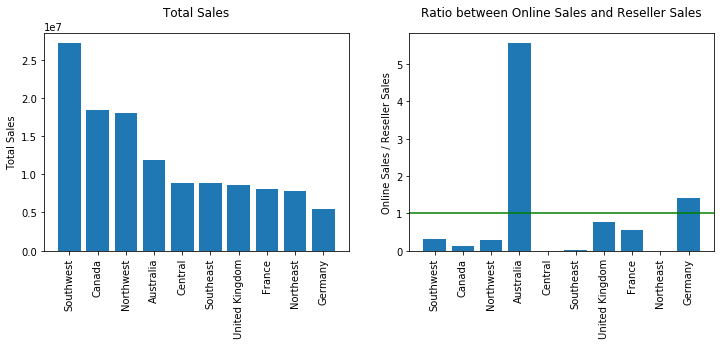

In [72]:
# Visualize total sales data and the sales data by territory

fig = plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(df.TerriName, df.Total, width=0.8)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel('Total Sales')
ax1.set_title('Total Sales',fontsize=12,y=1.05)

ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(df.TerriName, df.Ratio, width=0.8)
ax2.xaxis.set_tick_params(rotation=90)
ax2.axhline(y=1, color='green')
ax2.set_ylabel('Online Sales / Reseller Sales')
ax2.set_title('Ratio between Online Sales and Reseller Sales', fontsize=12,y=1.05)

#### 2) Retrieve and visualize sales quota and total sales by territory by sales reps

In [73]:
""" Retriving sales quota and total sales by sales representatives and by territory by joinning HumanResources.Employee, 
Person.Person, Sales.SalesPerson and Sales.SalesOrderHeader tables. """ 

df_emp_quota = pd.read_sql("""WITH emp AS (
                                SELECT  he.BusinessEntityID,
                                        pp.FirstName,
                                        he.JobTitle,
                                        sp.TerritoryID,
                                        sp.SalesQuota,
                                        sp.SalesYTD
                                FROM HumanResources.Employee he
                                INNER JOIN Person.Person pp ON pp.BusinessEntityID = he.BusinessEntityID
                                INNER JOIN Sales.SalesPerson sp ON sp.BusinessEntityID = he.BusinessEntityID
                                WHERE he.JobTitle LIKE 'Sales Representative')
                                
                                SELECT  e.BusinessEntityID, 
                                        e.FirstName,
                                        sh.TerritoryID, 
                                        st.Name AS TerriName, 
                                        sh.OnlineOrderFlag, 
                                        e.SalesQuota, 
                                        SUM(sh.TotalDue) AS Sale_Total,
                                        e.SalesYTD, 
                                        SUM(sh.TotalDue)/e.SalesQuota AS Sales_ratio
                                FROM Sales.SalesOrderHeader sh
                                INNER JOIN emp e ON e.BusinessEntityID = sh.SalesPersonID
                                INNER JOIN Sales.SalesTerritory st ON st.TerritoryID = sh.TerritoryID
                                GROUP BY e.BusinessEntityID,
                                         e.FirstName,
                                         sh.TerritoryID, 
                                         st.Name, 
                                         sh.OnlineOrderFlag, 
                                         e.SalesQuota,
                                         e.SalesYTD
                                ORDER BY e.BusinessEntityID,
                                         e.FirstName,
                                         sh.TerritoryID, 
                                         st.Name, 
                                         sh.OnlineOrderFlag, 
                                         e.SalesQuota,
                                         e.SalesYTD;""", conn)
                                                                        
df_emp_quota.head(2)

,BusinessEntityID,FirstName,TerritoryID,TerriName,OnlineOrderFlag,SalesQuota,Sale_Total,SalesYTD,Sales_ratio
0,275,Michael,2,Northeast,False,300000.0,3.301670e+06,3.763178e+06,11.0055
1,275,Michael,3,Central,False,300000.0,2.899017e+06,3.763178e+06,9.6633


In [74]:
# Checking for the size and missing values in df_emp_sum

print('(row, columns) =', df_emp_quota.shape, '\n')
print(df_emp_quota.isnull().sum())

(row, columns) = (25, 9) 

BusinessEntityID    0
FirstName           0
TerritoryID         0
TerriName           0
OnlineOrderFlag     0
SalesQuota          0
Sale_Total          0
SalesYTD            0
Sales_ratio         0
dtype: int64


In [75]:
""" Transforming data to get information on total sales, sales quota, the nubmer of territories each sales 
representative cover and the ratio between total sales and sale quota by sales representatives. """

# Getting summary data

df = df_emp_quota.groupby(['FirstName']).agg({'Sale_Total': np.sum})
df1 = df_emp_quota.groupby(['FirstName']).agg({'TerritoryID': 'count'})
df2 = df_emp_quota.groupby(['FirstName']).agg({'SalesQuota': 'unique'})
quota = [np.asscalar(a) for a in df2.SalesQuota]
df2['SalesQuota'] = quota

# Combining summary data

df = pd.concat([df, df1, df2], axis=1, join='inner')
df['TerriCount'] = df.TerritoryID
df['RepName'] = list(df.index)
df['Sales_ratio'] = df.Sale_Total/df.SalesQuota
df = df.drop(['TerritoryID'], axis=1)
df = df.sort_values('Sale_Total', ascending=False)
df.head()

,Sale_Total,SalesQuota,TerriCount,RepName,Sales_ratio
FirstName,,,,,
Linda,1.169502e+07,250000.0,3,Linda,46.780076
Jillian,1.134239e+07,250000.0,4,Jillian,45.369544
Michael,1.047537e+07,300000.0,4,Michael,34.917890
Jae,9.585125e+06,250000.0,1,Jae,38.340500
Tsvi,8.086074e+06,300000.0,1,Tsvi,26.953579


Text(0.5, 1.05, 'Average Total Sales per Territory')

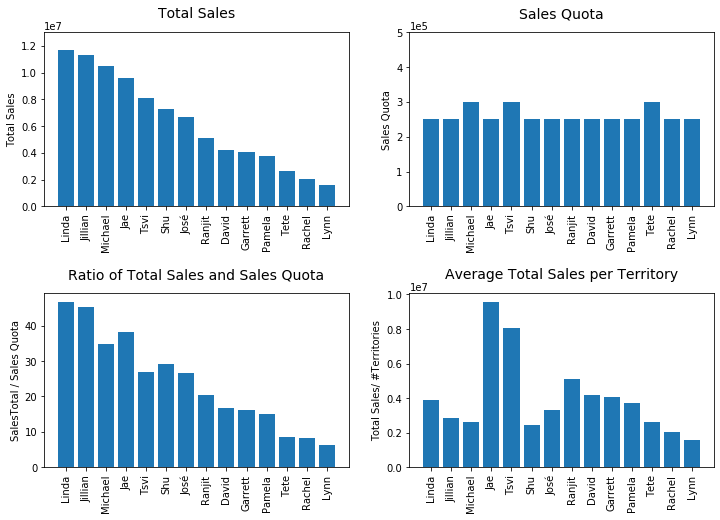

In [76]:
# Visualizing sales performance by sales representatives

fig = plt.figure(figsize = (12,8))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(df.RepName, df.Sale_Total)
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylim(0,13000000)
ax1.set_ylabel('Total Sales')
ax1.set_title('Total Sales',fontsize=14,y=1.05)

ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(df.RepName, df.SalesQuota)
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_ylim(0,500000)
ax2.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax2.set_ylabel('Sales Quota')
ax2.set_title('Sales Quota', fontsize=14,y=1.05)

ax3 = fig.add_subplot(2, 2, 3)
ax3.bar(df.RepName, df.Sales_ratio)
ax3.xaxis.set_tick_params(rotation=90)
ax3.set_ylabel('SalesTotal / Sales Quota')
ax3.set_title('Ratio of Total Sales and Sales Quota', fontsize=14,y=1.05)

ax4 = fig.add_subplot(2, 2, 4)
ax4.bar(df.RepName, df.Sale_Total/df.TerriCount)
ax4.xaxis.set_tick_params(rotation=90)
ax4.set_ylabel('Total Sales/ #Territories')
ax4.set_title('Average Total Sales per Territory',fontsize=14,y=1.05)

##### 3) Investigating why total sales are so much higher that the quotas.  
It can be seen from the graph above that total sales by each sales representative are much higher than the quotas.   Is this real or due to some abnormality in the dataset?  

In [77]:
# Retriving sales person info from Sales.SalesPerson table

df_view = pd.read_sql("""SELECT  BusinessEntityID,
                                 SalesQuota,
                                 SalesYTD
                     FROM Sales.SalesPerson;""", conn)
                                                    
df_view.head(2) 

,BusinessEntityID,SalesQuota,SalesYTD
0,274,NaN,5.596976e+05
1,275,300000.0,3.763178e+06


It can be seen that based on the above result, the sales quota and SalesYTD for sales rep 275 are the same as seen in df_emp_sum dataframe above and is much larger than the quota.  

##### 5) Transforming and visualizing sales quota and total sales by territory and by individual sales rep.

In [78]:
# Creating a dictionary containing separate dataframes for each sales rep with x-axis including all territories

terri_names = list(df_terri.TerriName.unique())
first_names = list(df.RepName)
df_rep = pd.DataFrame(terri_names, columns=['TerriName']) # create a dataframe initially only containing territory names

df_dict = {}

for n in first_names:
    df_dict[n] = df_emp_quota[df_emp_quota.FirstName == n] # generating a new dataframe for a sales rep
    
    # Reshaping dataframes so that they contain all the territories of interest for commparisons purpose
    df_rep.copy = pd.concat([df_rep, df_dict[n]], sort=True) # add territory name to the new dataframe
    df_rep.copy = df_rep.copy.fillna(0) # fill in zeros if there is no sales data.
    df_dict[n] = df_rep.copy[['TerriName', 'Sales_ratio']]

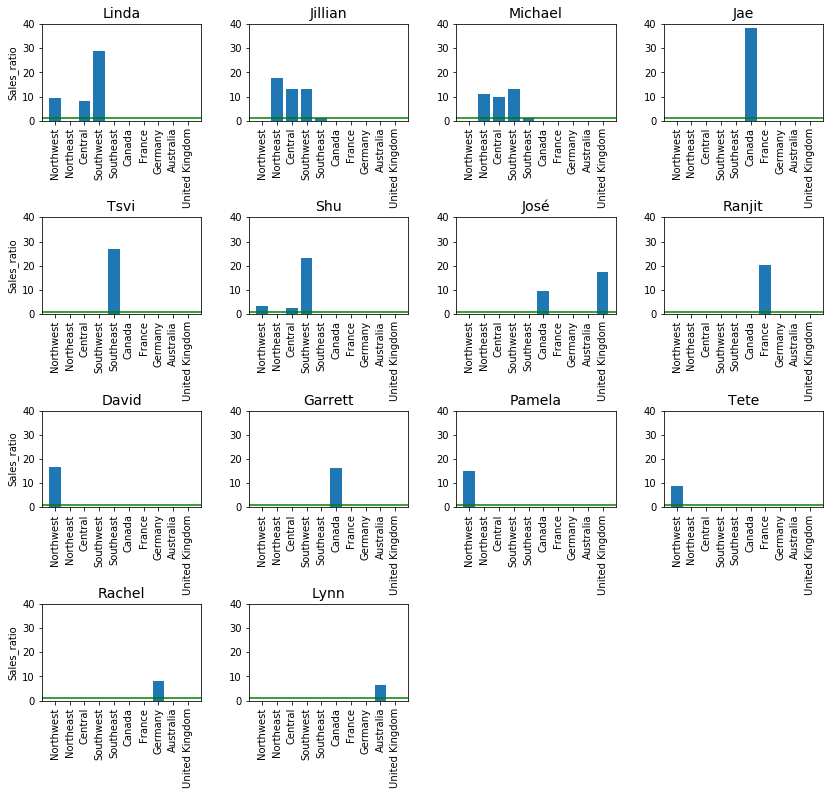

In [79]:
# Visualiing total sales by territory by each sales rep

fig = plt.figure(figsize = (14,16))
fig.subplots_adjust(hspace=1, wspace=0.3)

for i in range(14):
    ax = fig.add_subplot(5, 4, i+1)
    ax.bar(df_dict[first_names[i]].TerriName, df_dict[first_names[i]].Sales_ratio, width=0.8)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0,40)
    ax.axhline(y=1, color='green') # y=1 indicates equal values for the quota and the Sales ratio
    ax.set_title(first_names[i], fontsize=14)
    if i%4 == 0:
        ax.set_ylabel('Sales_ratio')

#### 4) Summary all sales by territory

In [80]:
# Retrieving teeritorial sales information from Sales.SalesTerritory table

df_Territory = pd.read_sql("""SELECT * FROM sales.SalesTerritory; """, conn)
df_Territory.head(2)

,TerritoryID,Name,CountryRegionCode,Group,SalesYTD,SalesLastYear,CostYTD,CostLastYear,rowguid,ModifiedDate
0,1,Northwest,US,North America,7.887187e+06,3.298694e+06,0.0,0.0,43689A10-E30B-497F-B0DE-11DE20267FF7,2002-06-01
1,2,Northeast,US,North America,2.402177e+06,3.607149e+06,0.0,0.0,00FB7309-96CC-49E2-8363-0A1BA72486F2,2002-06-01


In [81]:
# Checking to make sure each Name is linked to one TerritoryID

print(len(df_Territory.TerritoryID.unique()))
print(len(df_Territory.Name.unique()))

10
10


In [82]:
# Checking for the size and missing values in df_Territory

print('(row, columns) =', df_Territory.shape, '\n')
print(df_Territory.isnull().sum())

(row, columns) = (10, 10) 

TerritoryID          0
Name                 0
CountryRegionCode    0
Group                0
SalesYTD             0
SalesLastYear        0
CostYTD              0
CostLastYear         0
rowguid              0
ModifiedDate         0
dtype: int64


In [83]:
# Determining percent sales by territory

df_Territory['Percent_sale_ly'] = round(df_Territory.SalesLastYear/df_Territory.SalesLastYear.sum()*100, 1)
df_Territory['Percent_YTD'] = round(df_Territory.SalesYTD/df_Territory.SalesYTD.sum() *100, 1)
df_Territory = df_Territory.sort_values('Percent_sale_ly', ascending=False)
df_Territory.head()

,TerritoryID,Name,CountryRegionCode,Group,SalesYTD,SalesLastYear,CostYTD,CostLastYear,rowguid,ModifiedDate,Percent_sale_ly,Percent_YTD
5,6,Canada,CA,North America,6.771829e+06,5.693989e+06,0.0,0.0,06B4AF8A-1639-476E-9266-110461D66B00,2002-06-01,17.4,12.8
3,4,Southwest,US,North America,1.051085e+07,5.366576e+06,0.0,0.0,DC3E9EA0-7950-4431-9428-99DBCBC33865,2002-06-01,16.4,19.9
4,5,Southeast,US,North America,2.538667e+06,3.925071e+06,0.0,0.0,6DC4165A-5E4C-42D2-809D-4344E0AC75E7,2002-06-01,12.0,4.8
1,2,Northeast,US,North America,2.402177e+06,3.607149e+06,0.0,0.0,00FB7309-96CC-49E2-8363-0A1BA72486F2,2002-06-01,11.0,4.6
0,1,Northwest,US,North America,7.887187e+06,3.298694e+06,0.0,0.0,43689A10-E30B-497F-B0DE-11DE20267FF7,2002-06-01,10.1,15.0


Text(0.5, 1.05, 'Ratio of Territorial Sales YTD and SalesLastYear')

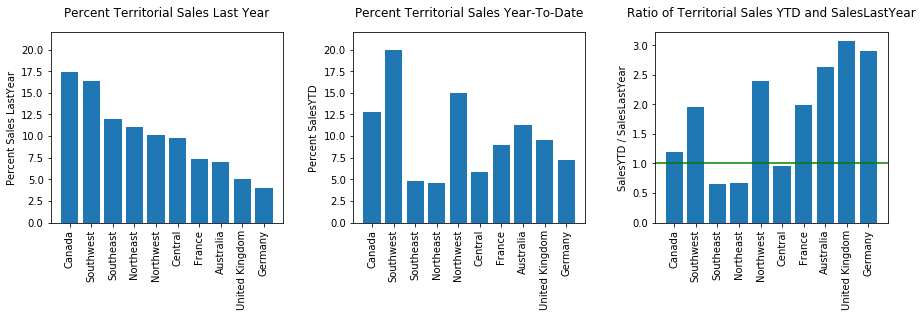

In [84]:
# Comparing last years sale and sales YTD.  Ranked by sales last year

fig = plt.figure(figsize=(15,3.5))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

plt.subplot(1, 3, 1)
plt.bar(df_Territory.Name, df_Territory.Percent_sale_ly)
plt.ylabel('Percent Sales LastYear')
plt.ylim(0,22)
plt.xticks(rotation=90)
plt.title('Percent Territorial Sales Last Year', fontsize=12,y=1.05)

plt.subplot(1, 3, 2)
plt.bar(df_Territory.Name, df_Territory.Percent_YTD)
plt.ylabel('Percent SalesYTD')
plt.ylim(0,22)
plt.xticks(rotation=90)
plt.title('Percent Territorial Sales Year-To-Date', fontsize=12,y=1.05)

plt.subplot(1, 3, 3)
plt.bar(df_Territory.Name, df_Territory.SalesYTD/df_Territory.SalesLastYear)
plt.ylabel('SalesYTD / SalesLastYear')
plt.xticks(rotation=90)
plt.axhline(y=1, color='g', linestyle='-') # y=1 indicates equal values for salesYTD and SalesLastYear
plt.title('Ratio of Territorial Sales YTD and SalesLastYear', fontsize=12,y=1.05)

#### 5) Examine total sales and reseller sales 
Given there are changes in the patterns for total sales between last year and SalrsYTD, it is of interest to examine reseller sales too. 

In [85]:
# Retriving sales data by store and by sales representative 

df_ter_str_emp = pd.read_sql("""WITH emp AS (
                                       SELECT  he.BusinessEntityID,
                                               pp.FirstName,
                                               he.JobTitle
                                       FROM HumanResources.Employee he
                                       INNER JOIN Person.Person pp ON pp.BusinessEntityID = he.BusinessEntityID
                                       INNER JOIN Sales.SalesPerson ss ON ss.BusinessEntityID = he.BusinessEntityID
                                       WHERE he.JobTitle LIKE 'Sales Representative')

                                SELECT ss.Name AS Store_name,
                                       e.FirstName,
                                       SUM(sh.TotalDue) AS Total_sale
                                FROM sales.SalesOrderHeader sh
                                INNER JOIN Sales.Store ss ON ss.SalesPersonID = sh.SalesPersonID
                                INNER JOIN emp e ON e.BusinessEntityID = sh.SalesPersonID
                                WHERE sh.OnlineOrderFlag = 0 
                                GROUP BY ss.Name,
                                         e.FirstName
                                ORDER BY ss.Name,
                                         e.FirstName;""", conn)
                                                                                
df_ter_str_emp.head(2)                               

,Store_name,FirstName,Total_sale
0,A Bicycle Association,Michael,1.047537e+07
1,A Bike Store,Pamela,3.748246e+06


In [86]:
# Checking for the size and missing values in df_emp_sum

print('(row, columns) =', df_ter_str_emp.shape, '\n')
print(df_ter_str_emp.isnull().sum())

(row, columns) = (701, 3) 

Store_name    0
FirstName     0
Total_sale    0
dtype: int64


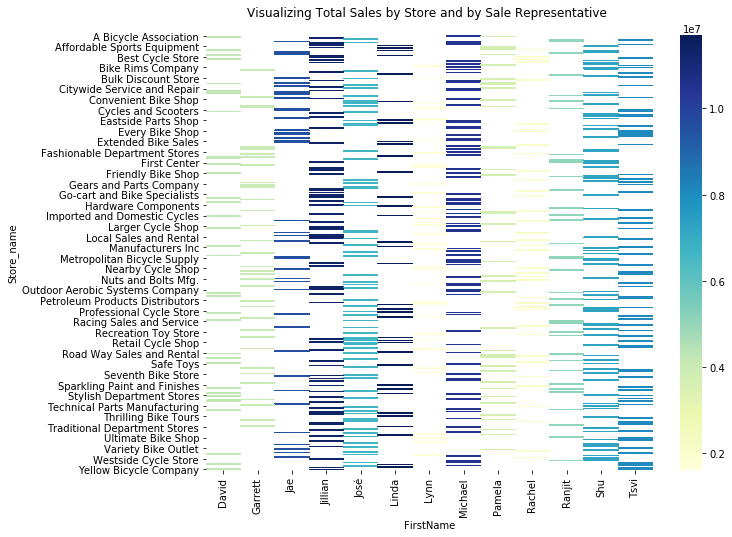

In [87]:
# Visualizing total sales by store and by sale representatives 

import seaborn as sns
plt.figure(figsize=(10,8))
plt.title('Visualizing Total Sales by Store and by Sale Representative ', y=1.03)
tmp = df_ter_str_emp.pivot('Store_name','FirstName','Total_sale')
sns.heatmap(tmp, cmap="YlGnBu")

In [88]:
grouped = df_ter_str_emp.groupby(['FirstName'])
grouped.describe()

Total_sale                                                          \
               count          mean           std           min           25%   
FirstName                                                                      
David           38.0  4.207895e+06  9.438241e-10  4.207895e+06  4.207895e+06   
Garrett         40.0  4.069422e+06  0.000000e+00  4.069422e+06  4.069422e+06   
Jae             40.0  9.585125e+06  5.659122e-09  9.585125e+06  9.585125e+06   
Jillian         76.0  1.134239e+07  1.125013e-08  1.134239e+07  1.134239e+07   
José            74.0  6.683537e+06  5.626079e-09  6.683537e+06  6.683537e+06   
Linda           39.0  1.169502e+07  9.434972e-09  1.169502e+07  1.169502e+07   
Lynn            40.0  1.606441e+06  9.431870e-10  1.606441e+06  1.606441e+06   
Michael         77.0  1.047537e+07  1.499887e-08  1.047537e+07  1.047537e+07   
Pamela          38.0  3.748246e+06  2.359560e-09  3.748246e+06  3.748246e+06   
Rachel          40.0  2.062393e+06  2.357968e-09  2.062393e+06  2.062393e+06   
Ranjit          40.0  5.087977e+06  2.829561e-09  5.087977e+06  5.087977e+06   
Shu             79.0  7.259568e+06  1.874547e-09  7.259568e+06  7.259568e+06   
Tsvi            80.0  8.086074e+06  5.623191e-09  8.086074e+06  8.086074e+06   

                                                     
                    50%           75%           max  
FirstName                                            
David      4.207895e+06  4.207895e+06  4.207895e+06  
Garrett    4.069422e+06  4.069422e+06  4.069422e+06  
Jae        9.585125e+06  9.585125e+06  9.585125e+06  
Jillian    1.134239e+07  1.134239e+07  1.134239e+07  
José       6.683537e+06  6.683537e+06  6.683537e+06  
Linda      1.169502e+07  1.169502e+07  1.169502e+07  
Lynn       1.606441e+06  1.606441e+06  1.606441e+06  
Michael    1.047537e+07  1.047537e+07  1.047537e+07  
Pamela     3.748246e+06  3.748246e+06  3.748246e+06  
Rachel     2.062393e+06  2.062393e+06  2.062393e+06  
Ranjit     5.087977e+06  5.087977e+06  5.087977e+06  
Shu        7.259568e+06  7.259568e+06  7.259568e+06  
Tsvi       8.086074e+06  8.086074e+06  8.086074e+06

#### 3) Investigating why the total sales by the same sales presentative at different stores are the same. 
As shown in the above examples, sales are the same at different stores for the same sales representative.

In [89]:
# Retriving individual sales data by store and sales representative's name to varify the above result

df_ter_str_emp_test = pd.read_sql("""WITH emp AS (
                                     SELECT  he.BusinessEntityID,
                                             pp.FirstName,
                                             he.JobTitle
                                     FROM HumanResources.Employee he
                                     INNER JOIN Person.Person pp ON pp.BusinessEntityID = he.BusinessEntityID
                                     INNER JOIN Sales.SalesPerson sp ON sp.BusinessEntityID = he.BusinessEntityID
                                     WHERE he.JobTitle LIKE 'Sales Representative')

                                SELECT   ss.Name AS Store_name,
                                         e.FirstName,
                                         sh.TotalDue
                                FROM sales.SalesOrderHeader sh
                                INNER JOIN Sales.Store ss ON ss.SalesPersonID = sh.SalesPersonID
                                INNER JOIN emp e ON e.BusinessEntityID = sh.SalesPersonID
                                WHERE sh.OnlineOrderFlag = 0 AND e.FirstName LIKE '%Michael'
                                ORDER BY ss.Name,
                                         e.FirstName,
                                         sh.TotalDue DESC;""", conn)
                                                                                
df_ter_str_emp_test.head(2)                               

,Store_name,FirstName,TotalDue
0,A Bicycle Association,Michael,165028.7482
1,A Bicycle Association,Michael,120512.2708


In [90]:
# Checking for the size and missing values in df_emp_sum

print('(row, columns) =', df_ter_str_emp_test.shape, '\n')
print(df_ter_str_emp_test.isnull().sum())

(row, columns) = (34650, 3) 

Store_name    0
FirstName     0
TotalDue      0
dtype: int64


In [91]:
# Retrieving top ten sales transactions made by Michael at Active Cycling

df = df_ter_str_emp_test[df_ter_str_emp_test.Store_name == 'Active Cycling'].sort_values(by='TotalDue', ascending =False)
df.head(10)

,Store_name,FirstName,TotalDue
450,Active Cycling,Michael,165028.7482
451,Active Cycling,Michael,120512.2708
452,Active Cycling,Michael,118581.3375
453,Active Cycling,Michael,116463.9102
454,Active Cycling,Michael,113231.0188
455,Active Cycling,Michael,110266.9588
456,Active Cycling,Michael,106618.2647
457,Active Cycling,Michael,102017.9004
458,Active Cycling,Michael,100902.4370
459,Active Cycling,Michael,99952.4380


In [92]:
# Retrieving top ten sales transactions made by Michael at Grand Discount Store


df = df_ter_str_emp_test[df_ter_str_emp_test.Store_name == 'Grand Discount Store'].sort_values(by='TotalDue', ascending =False)
df.head(10)

,Store_name,FirstName,TotalDue
13950,Grand Discount Store,Michael,165028.7482
13951,Grand Discount Store,Michael,120512.2708
13952,Grand Discount Store,Michael,118581.3375
13953,Grand Discount Store,Michael,116463.9102
13954,Grand Discount Store,Michael,113231.0188
13955,Grand Discount Store,Michael,110266.9588
13956,Grand Discount Store,Michael,106618.2647
13957,Grand Discount Store,Michael,102017.9004
13958,Grand Discount Store,Michael,100902.4370
13959,Grand Discount Store,Michael,99952.4380


In [93]:
# Retrieving top ten sales transactions made by Michael at Retail Sales and Service

df = df_ter_str_emp_test[df_ter_str_emp_test.Store_name == 'Retail Sales and Service'].sort_values(by='TotalDue', ascending =False)
df.head(10)

,Store_name,FirstName,TotalDue
27000,Retail Sales and Service,Michael,165028.7482
27001,Retail Sales and Service,Michael,120512.2708
27002,Retail Sales and Service,Michael,118581.3375
27003,Retail Sales and Service,Michael,116463.9102
27004,Retail Sales and Service,Michael,113231.0188
27005,Retail Sales and Service,Michael,110266.9588
27006,Retail Sales and Service,Michael,106618.2647
27007,Retail Sales and Service,Michael,102017.9004
27008,Retail Sales and Service,Michael,100902.4370
27009,Retail Sales and Service,Michael,99952.4380


In [94]:
# Retriving individual sales data by store and by sales representatives

df_sr = pd.read_sql("""WITH emp AS (
                                     SELECT  he.BusinessEntityID,
                                             pp.FirstName,
                                             he.JobTitle
                                     FROM HumanResources.Employee he
                                     INNER JOIN Person.Person pp ON pp.BusinessEntityID = he.BusinessEntityID
                                     INNER JOIN Sales.SalesPerson sp ON sp.BusinessEntityID = he.BusinessEntityID
                                     WHERE he.JobTitle LIKE 'Sales Representative')

                                SELECT   ss.Name AS Store_name,
                                         e.FirstName,
                                         sh.TotalDue
                                FROM sales.SalesOrderHeader sh
                                INNER JOIN Sales.Store ss ON ss.SalesPersonID = sh.SalesPersonID
                                INNER JOIN emp e ON e.BusinessEntityID = sh.SalesPersonID
                                WHERE sh.OnlineOrderFlag = 0
                                ORDER BY ss.Name,
                                         e.FirstName,
                                         sh.TotalDue DESC;""", conn)
                                                                                
df_sr.head(2)                      

,Store_name,FirstName,TotalDue
0,A Bicycle Association,Michael,165028.7482
1,A Bicycle Association,Michael,120512.2708


In [95]:
# Summarizing store sales by store name and by sales representative

df = df_sr.groupby(['Store_name', 'FirstName']).sum()
df.reset_index(inplace = True)
s_name = list(df.Store_name)

# Creating a dictionary containing the top sales trsaction in each store

df_dict ={}
for n in s_name:
    df_dict[n] = df[df.Store_name == n].sort_values('TotalDue',ascending=False).head(1)
    
# Combing top one sale data from each store into a new dataframe   

df = df_dict[s_name[0]]
for n in s_name[1:]:
    df = df.append(df_dict[n])

In [96]:
# Finding out how many total stores in the data set

n_stores = df.Store_name.value_counts()
print('Total store counts = ', df.shape)

Total store counts =  (701, 3)


In [97]:
# Finding stores with more than one sales representative

n_stores[n_stores > 1]

Friendly Bike Shop       2
Sports Products Store    2
Name: Store_name, dtype: int64

In [98]:
# Retrieving sales data from stores that had more than one sales representative

df = df[(df.Store_name == 'Friendly Bike Shop') | (df.Store_name == 'Sports Products Store')]
df.sort_values(['Store_name', 'TotalDue', 'FirstName'], ascending=False)

,Store_name,FirstName,TotalDue
569,Sports Products Store,Linda,1.169502e+07
569,Sports Products Store,Linda,1.169502e+07
222,Friendly Bike Shop,Michael,1.047537e+07
222,Friendly Bike Shop,Michael,1.047537e+07


#### 6) Analyzing product sale by product line

In [99]:
# Retriving product information by productline

q = """SELECT  pp.ProductLine,
               st.Name AS Territory_name,
               SUM(sh.TotalDue) AS Total_sale
       FROM Sales.SalesOrderDetail sd 
       INNER JOIN Production.Product pp ON pp.ProductID = sd.ProductID
       INNER JOIN Sales.SalesOrderHeader sh ON sh.SalesOrderID = sd.SalesOrderID
       INNER JOIN Sales.SalesTerritory st ON st.TerritoryID = sh.TerritoryID
       GROUP BY pp.ProductLine,
                st.Name;"""
       
df_product = pd.read_sql(q, conn)
df_product.head(2)

,ProductLine,Territory_name,Total_sale
0,T,Central,9.104702e+06
1,S,Australia,1.727607e+07


In [100]:
# Checking for the size and missing values in df_product

print('(row, columns) =', df_product.shape, '\n')
print(df_product.isnull().sum())

(row, columns) = (50, 3) 

ProductLine       10
Territory_name     0
Total_sale         0
dtype: int64


In [101]:
# Dropping rows with missing values in ProductLine column

df_product = df_product.dropna()
df_product = df_product.sort_values('Total_sale', ascending=False)
print(df_product.isnull().sum(), '\n')
print(df_product.ProductLine.unique())

ProductLine       0
Territory_name    0
Total_sale        0
dtype: int64 

['R ' 'M ' 'S ' 'T ']


Text(0.5, 1.05, 'Total Sales by ProductLine')

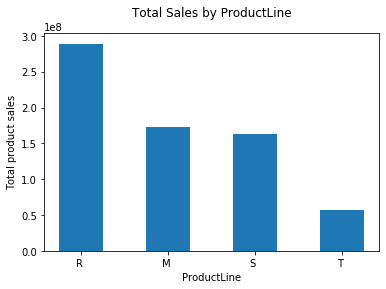

In [102]:
# Visualizing product sales by productline

fig = plt.figure(figsize=(6,4))

plt.bar(df_product.ProductLine, df_product.Total_sale, width=0.5)
plt.ylabel('Total product sales')
plt.xlabel('ProductLine')
plt.title('Total Sales by ProductLine', fontsize=12,y=1.05)

#### 7) Analyzing product sales by territory

In [103]:
# Retriving product information by productline and by territory

q = """SELECT  sd.ProductID,
               pp.Name AS Product_name,
               pp.ProductLine,
               st.Name AS Territory_name,
               SUM(sh.TotalDue) AS Total_sale
       FROM Sales.SalesOrderDetail sd 
       INNER JOIN Production.Product pp ON pp.ProductID = sd.ProductID
       INNER JOIN Sales.SalesOrderHeader sh ON sh.SalesOrderID = sd.SalesOrderID
       INNER JOIN Sales.SalesTerritory st ON st.TerritoryID = sh.TerritoryID
       GROUP BY pp.ProductLine,
                sd.ProductID,
                pp.Name,
                st.Name;"""
       
df_product_t = pd.read_sql(q, conn)
df_product_t.head(2)

,ProductID,Product_name,ProductLine,Territory_name,Total_sale
0,831,"ML Mountain Frame - Black, 44",M,Canada,1.913921e+06
1,815,LL Mountain Front Wheel,M,Northwest,1.825971e+06


In [104]:
# Checking for the size and missing values in df_product

print('(row, columns) =', df_product_t.shape, '\n')
print(df_product_t.isnull().sum())

(row, columns) = (2446, 5) 

ProductID           0
Product_name        0
ProductLine       139
Territory_name      0
Total_sale          0
dtype: int64


In [105]:
# Dropping rows with missing values in ProductLine column

df_product_t = df_product_t.dropna()
df_product_t = df_product_t.sort_values('Total_sale', ascending=False)
print(df_product_t.isnull().sum(), '\n')

ProductID         0
Product_name      0
ProductLine       0
Territory_name    0
Total_sale        0
dtype: int64 



In [106]:
print(terri_names)

['Northwest', 'Northeast', 'Central', 'Southwest', 'Southeast', 'Canada', 'France', 'Germany', 'Australia', 'United Kingdom']


In [107]:
# Creating a dictionary containing separate dataframes for each territory containing the top selling product 

df_dict = {}
for n in terri_names:
    df_dict[n] = df_product_t[df_product_t.Territory_name == n].sort_values(['Total_sale'],ascending=False).head(1)
    
df = df_dict[terri_names[0]]
for n in terri_names[1:]:
    df = df.append(df_dict[n])
    
df = df.sort_values('Total_sale', ascending=False)
df

,ProductID,Product_name,ProductLine,Territory_name,Total_sale
1331,712,AWC Logo Cap,S,Southwest,1.217849e+07
2254,715,"Long-Sleeve Logo Jersey, L",S,Canada,9.089475e+06
1198,712,AWC Logo Cap,S,Northwest,6.337214e+06
571,712,AWC Logo Cap,S,Central,4.779110e+06
1959,712,AWC Logo Cap,S,Northeast,4.309207e+06
2130,712,AWC Logo Cap,S,Southeast,4.135538e+06
1303,712,AWC Logo Cap,S,United Kingdom,3.092073e+06
1518,712,AWC Logo Cap,S,France,2.696381e+06
796,870,Water Bottle - 30 oz.,S,Germany,2.133513e+06
1556,870,Water Bottle - 30 oz.,S,Australia,1.803794e+06


In [108]:
# Creating a dictionary containing separate dataframes for each territory containing the 3 top selling products

df_dict = {}
for n in terri_names:
    df_dict[n] = df_product_t[df_product_t.Territory_name == n].sort_values(['Total_sale'],ascending=False).head(3)
    
df = df_dict[terri_names[0]]
for n in terri_names[1:]:
    df = df.append(df_dict[n])
    
df = df.sort_values('Total_sale', ascending=False)
df

,ProductID,Product_name,ProductLine,Territory_name,Total_sale
1331,712,AWC Logo Cap,S,Southwest,1.217849e+07
454,715,"Long-Sleeve Logo Jersey, L",S,Southwest,1.203233e+07
2176,711,"Sport-100 Helmet, Blue",S,Southwest,1.135786e+07
2254,715,"Long-Sleeve Logo Jersey, L",S,Canada,9.089475e+06
442,712,AWC Logo Cap,S,Canada,9.032828e+06
2165,708,"Sport-100 Helmet, Black",S,Canada,8.533419e+06
1198,712,AWC Logo Cap,S,Northwest,6.337214e+06
599,715,"Long-Sleeve Logo Jersey, L",S,Northwest,6.007942e+06
2320,711,"Sport-100 Helmet, Blue",S,Northwest,5.772490e+06
571,712,AWC Logo Cap,S,Central,4.779110e+06
